# Imports

In [1]:
import sys
import os

# Dynamically add the root directory to sys.path
# Assumes that 'models' and 'utils' are in the same project root directory
project_root = os.path.abspath(os.path.join(os.path.dirname('.'), '..'))
sys.path.insert(0, project_root)


In [2]:
# sklearn
from sklearn.metrics import accuracy_score

# torch
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# torch eeg library
from torcheeg import transforms
from torch.utils.data import DataLoader
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from torcheeg.datasets import DREAMERDataset
from torcheeg.model_selection import KFoldGroupbyTrial
from torcheeg.model_selection import train_test_split_groupby_trial

# Other
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Local Imports
from utils.checkpoint import train_and_save
from utils.log import get_logger
from utils.utils import print_var, train_one_epoch, train_one_epoch_lstm, get_num_params, train_one_step_tqdm
from models.cnn import Two_Layer_CNN, Two_Layer_CNN_Pro, Simplified_CNN
from models.rnns import LSTM

In [12]:
from torcheeg.models import TSCeption


In [ ]:
# nice label transform
label_transform=transforms.Compose([
    transforms.Select(['valence', 'arousal']),
    transforms.Binary(5.0),
    transforms.BinariesToCategory()])

# Read Data

## load data

In [41]:
dataset_name = 'Dreamer_time_series_01'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

# Import data
dataset = DREAMERDataset(io_path=f"{io_path}",
                        mat_path=mat_path,
                        offline_transform=transforms.Compose([
                            transforms.MeanStdNormalize(),#MeanStdNormalize() , MinMaxNormalize()
                        ]),
                        online_transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        label_transform=transforms.Compose([
                            transforms.Select(emotion_dim),
                            transforms.Binary(threshold=2.5),
                             
                        ]),
                        chunk_size=128,
                        baseline_chunk_size=128,
                        num_baseline=61,
                        num_worker=4)



[2024-11-26 19:13:07] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../saves/datasets/Dreamer_time_series_01.


In [39]:
# To 2D for tsception

dataset_name = 'Dreamer_2D_1'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

dataset = DREAMERDataset(io_path=f"{io_path}",
                         mat_path=mat_path,
                         offline_transform=transforms.Compose([
                             transforms.BaselineRemoval(),
                             transforms.MeanStdNormalize(),
                             transforms.To2d()
                         ]),
                         online_transform=transforms.ToTensor(),
                         label_transform=transforms.Compose([
                             transforms.Select('valence'),
                             transforms.Binary(3.0)
                         ]),
                         chunk_size=128,
                         baseline_chunk_size=128,
                         num_baseline=61,
                         num_worker=4)

[2024-11-26 19:12:50] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../saves/datasets/Dreamer_2D_1.


In [40]:
dataset[0][0].shape

torch.Size([1, 14, 128])

IndexError: index 1 is out of bounds for dimension 0 with size 1

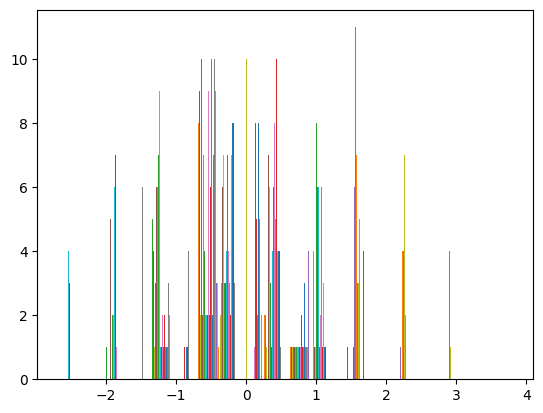

In [5]:
for i in range(14):
    plt.hist(dataset[100][0][i,:])


## Split data

In [42]:
rng_num = 122
train_dataset, test_dataset = train_test_split_groupby_trial(dataset= dataset, test_size = 0.2, shuffle= True, random_state= rng_num)
train_dataset, val_dataset = train_test_split_groupby_trial(dataset= train_dataset, test_size = 0.2, shuffle=True, random_state= rng_num)

[2024-11-26 19:13:13] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2024-11-26 19:13:13] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1732635793577_16LC4 for the next run, if you want to use the same setting for the experiment.
[2024-11-26 19:13:14] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2024-11-26 19:13:14] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1732635794622_YLb6S for the next run, if you want to use the same setting for the experiment.


In [43]:
len(train_dataset),len(val_dataset) , len(test_dataset), len(dataset)

(54533, 13869, 17342, 85744)

## create dataloader

In [44]:
train_loader = DataLoader(train_dataset, batch_size= 256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= 256, shuffle=False)

# Define model

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([256, 1, 14, 128])

In [23]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self,in_channel=14, hidden_size1=64, hidden_size2= 128, hidden_size_lstm= 256, num_layers= 1, num_classes=1, dropout_prob=0.5):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout_prob)
        self.af = nn.ReLU()
        
        # CNN
        self.conv1 = nn.Conv1d(in_channels= in_channel, out_channels=hidden_size1 , kernel_size= 3 ,padding=1)
        self.bn1 = nn.BatchNorm1d(num_features= hidden_size1)
        self.max_pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels= hidden_size1, out_channels=hidden_size2 , kernel_size= 3 ,padding=1)
        self.bn2 = nn.BatchNorm1d(num_features= hidden_size2)
        self.max_pool2 = nn.MaxPool1d(4)

        # LSTM
        self.num_layers = num_layers
        self.hidden_size_lstm = hidden_size_lstm
        self.lstm = nn.LSTM(hidden_size2, hidden_size_lstm, num_layers, batch_first=True)


        # fully connected
        self.fc = nn.LazyLinear(num_classes)


    def forward(self, x): # [batch, 14, 128]
        x = self.conv1(x) # [batch, 64, 64]
        x = self.bn1(x)
        x = self.af(x)
        x = self.dropout(x)
        x = self.max_pool1(x) # [batch, 64, 32]

        x = self.max_pool2(self.dropout(self.af(self.bn2(self.conv2(x))))) # [batch, 128, 16] -> F x L

        # lstm section
        x = x.permute(0, 2, 1) # (Batch, Length, features = 128 channels)
        # Initialize hidden state and cell state with random values
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size_lstm).to(x.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size_lstm).to(x.device)

        # Forward propagate the LSTM
        out, (_,_) = self.lstm(x, (h0, c0)) #

        # x = self.fc(out[:, -1, :])
        x = self.fc(out.flatten(1))
        x = nn.functional.sigmoid(x)

        return x


2048

# Test model with little data

In [279]:
x, y = next(iter(train_loader))
model = LSTM_CNN_Model()
print(model(x).shape)
print(get_num_params(model,1))

torch.Size([256, 1])
423361.0


In [ ]:
from torcheeg.models import TSCeption
# TSCeption config for DREAMER
model = TSCeption(num_electrodes=14,
                    num_classes=2,
                    num_T=15,
                    num_S=15,
                    in_channels=1,
                    hid_channels=32,
                    sampling_rate=128,
                    dropout=0.5)
model(next(iter(dataset))[0])

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [14, 128]

# Optimize learning parameters

# Train

In [28]:
model = LSTM_CNN_Model()
# model = TSCeption(num_electrodes=14,
#                     num_classes=1,
#                     num_T=15,
#                     num_S=15,
#                     in_channels=1,
#                     hid_channels=32,
#                     sampling_rate=128,
#                     dropout=0.5)

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

num_epochs = 400 # 300
model_name = model.__class__.__name__
print(f"Start training {model_name} for {num_epochs} epoch")

# Lists to store loss and accuracy values
loss_hist = []
acc_hist = []

# Initialize the best loss variable to track the least loss
best_loss = float('inf')  # Set to infinity initially to ensure it gets updated in the first epoch


for epoch in range(num_epochs):
    # Model training (assuming train_one_step_tqdm is implemented)
    model, loss, acc = train_one_step_tqdm(model, train_loader, loss_fn, optimizer, device, epoch, True)
    
    loss_hist.append(loss)
    acc_hist.append(acc)

print("Training process is done!")



Using device: cuda
Start training LSTM_CNN_Model for 400 epoch


  0%|          | 0/214 [00:00<?, ?batch/s]

Epoch: 399: 100%|██████████| 214/214 [00:11<00:00, 18.04batch/s, accuracy=95.2, loss=0.486]

Training process is done!


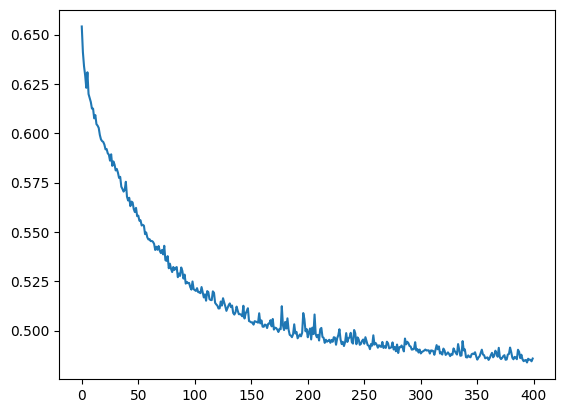

In [29]:
plt.plot(loss_hist)

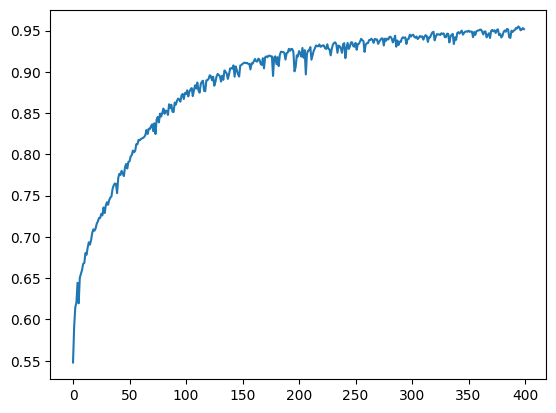

In [30]:
plt.plot(acc_hist)

# TSCeption


In [ ]:
class TSCEPTIONModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tsception = TSCeption(num_electrodes=14,
                        num_classes=1,
                        num_T=15,
                        num_S=15,
                        in_channels=1,
                        hid_channels=32,
                        sampling_rate=128,
                        dropout=0.5)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.tsception(x)
        return x

model = TSCEPTIONModel()

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

num_epochs = 10 # 300
model_name = model.__class__.__name__
print(f"Start training {model_name} for {num_epochs} epoch")

# Lists to store loss and accuracy values
loss_hist = []
acc_hist = []

# Initialize the best loss variable to track the least loss
best_loss = float('inf')  # Set to infinity initially to ensure it gets updated in the first epoch


for epoch in range(num_epochs):
    # Model training (assuming train_one_step_tqdm is implemented)
    model, loss, acc = train_one_step_tqdm(model, train_loader, loss_fn, optimizer, device, epoch, True)
    
    loss_hist.append(loss)
    acc_hist.append(acc)

print("Training process is done!")



Using device: cuda
Start training TSCEPTIONModel for 10 epoch


Epoch: 0:   1%|          | 2/214 [00:00<00:17, 12.13batch/s, accuracy=45.7, loss=0.712]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:   1%|          | 2/214 [00:00<00:17, 12.13batch/s, accuracy=44.9, loss=0.711]

torch.Size([256, 1, 14, 128])


Epoch: 0:   2%|▏         | 4/214 [00:00<00:15, 13.49batch/s, accuracy=45.4, loss=0.707]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:   3%|▎         | 6/214 [00:00<00:14, 14.15batch/s, accuracy=45.7, loss=0.705]

torch.Size([256, 1, 14, 128])


Epoch: 0:   4%|▎         | 8/214 [00:00<00:14, 14.17batch/s, accuracy=46.3, loss=0.704]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:   4%|▎         | 8/214 [00:00<00:14, 14.17batch/s, accuracy=45.9, loss=0.703]

torch.Size([256, 1, 14, 128])


Epoch: 0:   5%|▍         | 10/214 [00:00<00:14, 14.46batch/s, accuracy=46.4, loss=0.702]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:   6%|▌         | 12/214 [00:00<00:13, 14.60batch/s, accuracy=46.7, loss=0.701]

torch.Size([256, 1, 14, 128])


Epoch: 0:   7%|▋         | 14/214 [00:01<00:13, 14.75batch/s, accuracy=47.2, loss=0.701]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:   8%|▊         | 18/214 [00:01<00:13, 14.91batch/s, accuracy=48.2, loss=0.699]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  10%|█         | 22/214 [00:01<00:12, 14.94batch/s, accuracy=49.3, loss=0.696]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  12%|█▏        | 26/214 [00:01<00:12, 15.04batch/s, accuracy=50.4, loss=0.695]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  14%|█▍        | 30/214 [00:02<00:12, 15.01batch/s, accuracy=51, loss=0.694]  

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  15%|█▍        | 32/214 [00:02<00:12, 14.91batch/s, accuracy=52.1, loss=0.692]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  17%|█▋        | 36/214 [00:02<00:11, 15.01batch/s, accuracy=53.1, loss=0.69] 

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  19%|█▊        | 40/214 [00:02<00:11, 14.97batch/s, accuracy=53.6, loss=0.689]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  21%|██        | 44/214 [00:03<00:11, 14.97batch/s, accuracy=54.1, loss=0.688]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  22%|██▏       | 48/214 [00:03<00:11, 15.01batch/s, accuracy=54.5, loss=0.687]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  24%|██▍       | 52/214 [00:03<00:10, 15.07batch/s, accuracy=54.8, loss=0.686]

torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])
torch.Size([256, 1, 14, 128])


Epoch: 0:  25%|██▌       | 54/214 [00:03<00:10, 14.72batch/s, accuracy=54.9, loss=0.685]


KeyboardInterrupt: 